In [30]:
## Sample Data Analysis

In [1]:
import pandas as pd
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)

In [2]:
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [3]:
data.columns = ['West', 'East']
data.fillna(0, inplace=True)
data['Total'] = data.eval('East + West')

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot styling
import numpy as np

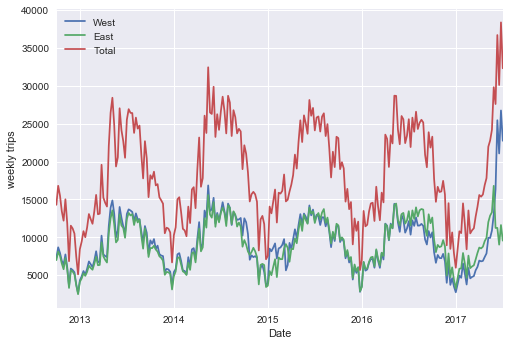

In [7]:
data.resample('W').sum().plot()
plt.ylabel('weekly trips');

In [8]:
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date,
                           columns=data.index.hour,
                           fill_value=0)
pivoted.head()

East                                    ... West                 \
Date         0  1  2  3  4   5   6    7    8    9  ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104 ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94 ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81 ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55 ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36 ...  126  122  132  118   

                                     
Date         18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

In [9]:
X = pivoted.values
X.shape

(1732, 48)

In [10]:
from sklearn.decomposition import PCA
Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

(1732, 3)

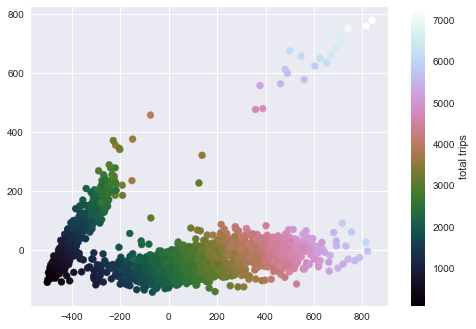

In [11]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='total trips');

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Func

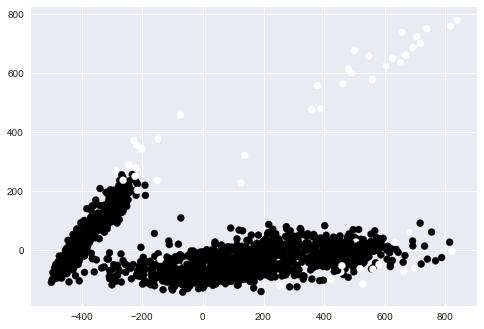

In [12]:
from sklearn.mixture import GMM
gmm = GMM(2, covariance_type='full', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label);

In [13]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'], on=data.index.date)
data.head()

,West,East,Total,Cluster
Date,,,,
2012-10-03 00:00:00,4.0,9.0,13.0,1
2012-10-03 01:00:00,4.0,6.0,10.0,1
2012-10-03 02:00:00,1.0,1.0,2.0,1
2012-10-03 03:00:00,2.0,3.0,5.0,1
2012-10-03 04:00:00,6.0,1.0,7.0,1


In [15]:
by_hour = data.groupby(['Cluster', data.index.time]).mean()
by_hour.head()

West      East      Total
Cluster                                        
0       00:00:00  8.873016  5.619048  14.492063
        01:00:00  4.063492  3.063492   7.126984
        02:00:00  3.841270  2.047619   5.888889
        03:00:00  2.238095  1.412698   3.650794
        04:00:00  5.079365  3.222222   8.301587

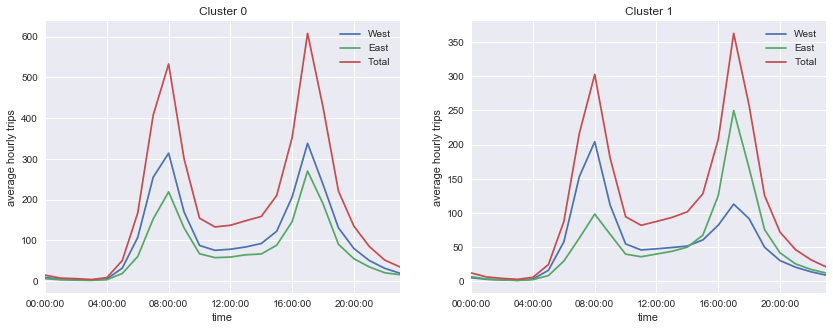

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hourly_ticks = 4 * 60 * 60 * np.arange(6)

for i in range(2):
    by_hour.loc[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

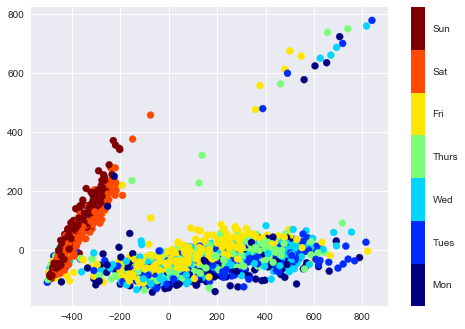

In [19]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7))
cb = plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5);

In [20]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)
results.head()

,cluster,is_weekend,weekday
2012-10-03,1,False,Wed
2012-10-04,1,False,Thu
2012-10-05,1,False,Fri
2012-10-06,1,True,Sat
2012-10-07,1,True,Sun


In [21]:
weekend_workdays = results.query('cluster == 0 and is_weekend')
len(weekend_workdays)

12

In [22]:
midweek_holidays = results.query('cluster == 1 and not is_weekend')
len(midweek_holidays)

1187

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
dtype: object

In [24]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head()

2012-01-01                 Day Before New Years Day
2012-01-02                            New Years Day
2012-01-03                  Day After New Years Day
2012-01-15    Day Before Dr. Martin Luther King Jr.
2012-01-16               Dr. Martin Luther King Jr.
dtype: object

In [25]:
holidays_all.name = 'name'  # required for join
joined = midweek_holidays.join(holidays_all)
set(joined['name'])

{nan,
 'Veterans Day',
 'MemorialDay',
 'Day After Veterans Day',
 'Day Before July 4th',
 'Day After MemorialDay',
 'Presidents Day',
 'Day After Columbus Day',
 'Columbus Day',
 'Day After Dr. Martin Luther King Jr.',
 'Day Before Christmas',
 'Christmas',
 'Dr. Martin Luther King Jr.',
 'Day After July 4th',
 'July 4th',
 'Day After Labor Day',
 'Day Before Veterans Day',
 'New Years Day',
 'Day After New Years Day',
 'Day Before Thanksgiving',
 'Day Before New Years Day',
 'Day After Presidents Day',
 'Thanksgiving',
 'Day After Christmas',
 'Labor Day',
 'Day After Thanksgiving'}

In [26]:
set(holidays) - set(joined.name)

set()

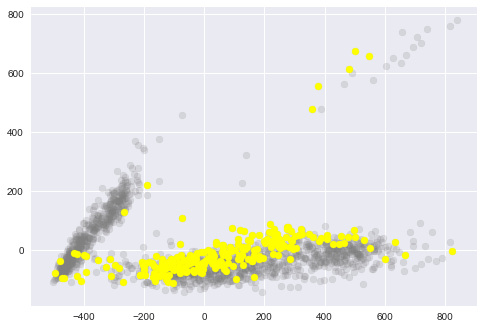

In [27]:
fridays = (dayofweek == 4)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c='yellow');

In [28]:
weird_fridays = pivoted.index[fridays & (Xpca[:, 0] < -600)]
weird_fridays

Index([], dtype='object')

In [29]:
all_days = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
all_days.loc[:, weird_fridays].plot();
all_days.mean(1).plot(color='gray', lw=5, alpha=0.3,
                      xticks=hourly_ticks);

TypeError: Empty 'DataFrame': no numeric data to plot